# Complex Networks Analysis Project: A Study of the Air Transportation Multiplex Dataset

This notebook is devoted to presenting all the code and reasonings of our project for the Complex Networks Analysis course of the Master in Fundamental Principles of Data Science.

Here, we analyze the "Air Transportation Multiplex" dataset, which contains a multiplex network of airline routes among European airports, where each of the 37 edge types represents routes by a different airline. It is an undirected, multiplex and unweighted network.

For **Task 1**, we have done the following work:

- **Data Reading and Network Visualization**.
- **Selection of Networks for Analysis**.
- **Microscale Analysis**.
- **Macroscale Analysis**.


***

### Necessary Imports and Directory Management


In [1]:
# Reset the kernel
%reset -f

# Necessary imports
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from tqdm.auto import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

from PIL import Image
import io

from pathlib import Path


In [2]:
# Directories
DATA_DIR = Path("../Data")
OUTPUT_DIR = Path("../Output")


***

## **TASK 1**

This week, we have focused our efforts on understanding the format of our dataset, loading the network and doing some basic exploration of it.

### **1. Data Reading and Network Visualization**

#### 1.1. Data Reading

In [38]:
# Read the file containing the airport information
df_airports = pd.read_csv(
    DATA_DIR / "airports.tsv",
    sep="\t",
    header=None,
    names=["node_id", "icao_code", "longitude", "latitude"],
)

# Read the file containing airport names
df_airport_names = pd.read_csv(
    DATA_DIR / "icao-to-airport-name.csv",
    sep=",",
    index_col=0,
)

# Join the two dataframes
df_airports = df_airports.join(
    df_airport_names, on="icao_code", how="left"
)


In [39]:
# Read the file containing the airport connections
def read_multilayer_connections(
    file_path: Path,
) -> list[dict]:
    """Reads the multilayer connections from a file.

    Args:
        file_path (Path) -- Path to the file containing the multilayer connections.

    Returns:
        list -- List containing the multilayer connections.
    """
    layers = []

    with Path.open(file_path, "r") as f_in:
        lines = [line.strip() for line in f_in if line.strip()]

    i = 0
    while i < len(lines):
        num_nodes = int(lines[i])
        i += 1

        edges = set()
        for _ in range(num_nodes):
            parts = lines[i].split()
            node_id = int(parts[0])
            neighbors = list(map(int, parts[2:]))
            for neighbor in neighbors:
                edge = tuple(sorted((node_id, neighbor)))  # Undirected
                edges.add(edge)
            i += 1

        layers.append({
            "active_nodes": num_nodes,
            "edges": edges
        })

    return layers


In [40]:
# Read the layers
layers = read_multilayer_connections(DATA_DIR / "network.txt")


In [41]:
# Convert each layer to a NetworkX graph
def create_graph_from_layer(layer: dict) -> nx.Graph:
    """Creates a NetworkX graph from a layer.

    Args:
        layer (dict) -- Layer containing the active nodes and edges.

    Returns:
        nx.Graph -- NetworkX graph.
    """
    G = nx.Graph()
    G.add_edges_from(layer["edges"])
    return G

# Create a list of NetworkX graphs for each layer
graphs = [create_graph_from_layer(layer) for layer in layers]


In [42]:
# Construct the newtork resulting from collapsing the multilayer network
def collapse_multilayer_network(layers: list[dict]) -> nx.Graph:
    """Collapses the multilayer network into a single layer.

    Args:
        layers (list) -- List containing the multilayer connections.

    Returns:
        nx.Graph -- Collapsed multilayer network.
    """
    G = nx.Graph()

    for layer in layers:
        edges = layer["edges"]
        G.add_edges_from(edges)

    return G

# Collapse the multilayer network
ntw_all = collapse_multilayer_network(layers)
graphs.append(ntw_all)


#### 1.2. Network Visualization

We have developed an interactive visualization of the network, consisting of a map with a selector that allows to visualize the transportation network for each of the 37 airlines.

<div class="alert alert-block alert-danger">
<b>IMPORTANT:</b> IN order for the visualization to be displayed, the corresponding notebook cells need to be rerun each time the notebook is opened. Please run all the cells to dynamically visualize the networks.
</div>

In [43]:
# Function to plot the graph as an interactive map
def plot_interactive_map(G: nx.Graph, df_airports: pd.DataFrame) -> folium.Map:
    """Visualizes the network on a folium map.

    Args:
        G (nx.Graph) -- NetworkX graph object.
        df_airports (pd.DataFrame) -- DataFrame containing airport information.

    Returns:
        folium.Map -- Folium map with the network visualized.
    """
    # Create a folium map centered around the average coordinates
    m = folium.Map(location=[df_airports["latitude"].mean(), df_airports["longitude"].mean()], zoom_start=2)

    # Add edges to the map
    for edge in G.edges():
        airport1 = df_airports[df_airports["node_id"] == edge[0]].iloc[0]
        airport2 = df_airports[df_airports["node_id"] == edge[1]].iloc[0]
        folium.PolyLine(
            locations=[[airport1["latitude"], airport1["longitude"]],
                       [airport2["latitude"], airport2["longitude"]]],
            color="blue",
            weight=2,
            opacity=0.6,
        ).add_to(m)

    # Add nodes to the map
    for node in G.nodes():
        airport = df_airports[df_airports["node_id"] == node].iloc[0]
        folium.CircleMarker(
            location=[airport["latitude"], airport["longitude"]],
            radius=3,
            color="red",
            fill=True,
            fill_color="red",
            popup=airport["name"],
        ).add_to(m)



    return m


In [ ]:
# Step 1: Load airline names from TSV
# Assuming TSV has two columns: 'layer' and 'airline_name'
df_airlines = pd.read_csv(DATA_DIR / "airlines.tsv", sep="\t")
airline_names = df_airlines.sort_values("Id")["Airline"].tolist()

# Step 2: Create dropdown with airline names
airline_dropdown = widgets.Dropdown(
    options=[(name, idx) for idx, name in enumerate(airline_names)],
    description='Airline:',
    style={'description_width': 'initial'}
)

# Output widget to hold the map
map_output = widgets.Output()

# Step 3: Define update function
def update_map(change):
    with map_output:
        clear_output(wait=True)
        layer_index = change['new']
        m = plot_interactive_map(
            graphs[layer_index],
            df_airports,
        )
        display(m)

# Step 4: Connect dropdown to update function
airline_dropdown.observe(update_map, names='value')

# Display the widgets
display(airline_dropdown, map_output)

# Step 5: Trigger initial map
airline_dropdown.value = 0  # or any initial valid index


Dropdown(description='Airline:', options=(('Lufthansa', 0), ('Ryanair', 1), ('Easyjet', 2), ('British Airways'…

Output()

By visually inspecting each airline’s network, we can identify distinct "families" based on their structural patterns:

- **Traditional airlines**, such as Lufthansa, Air France or SWISS, rely on a **hub and spoke** model. In this structure, a few central airports handle the majority of the traffic, serving as hubs through which most connections are routed.
- **Non-traditional, low-cost airlines**, such as Ryanair or WizzAir, tend to rely on a **point-to-point** model. This approach avoids centralized hubs, instead connecting airports more evenly and directly, with no single airport dominating the network.

### **2. Selection of Networks for Analysis**

Since the downloaded network includes data from 37 different airlines, we decided to perform data selection and focus our analysis on a subset of airline networks. This restriction allows for clearer visualizations and a more interpretable analysis of each airline’s network structure.

We have chosen to analyze the following airlines:

- **Lufthansa**: traditional hub-and-spoke airline. By visual inspection, we can see that presents not a single but few central nodes in major German airports.
- **Air France**: traditional hub-and-spoke airline. By visual inspection, we can see that presents a single central hub in Paris.
- **Ryanair**: non-traditional, low-cost airline. By visual inspection, we can see that its network is very dense and does not present any apparent central node.

Moreover, we construct and study the **network resulting from collapsing all airline networks toghether**, which we think is a good representation of general aviation traffic in Europe.

Our main goal here is to see whether centrality measures can quantitatively prove the qualitative, visual observations we have done on the network representations.


In [45]:
# Function to select the network corresponding to the chosen airline
def select_airline_network(
    airline_name: str,
    airline_df: pd.DataFrame,
    graphs: list[nx.Graph],
) -> nx.Graph:
    """Selects the network corresponding to the chosen airline.

    Args:
        airline_name (str) -- Name of the airline.
        airline_df (pd.DataFrame) -- DataFrame containing airline information.
        graphs (list[nx.Graph]) -- List of networks.

    Returns:
        nx.Graph -- Object containing the selected network.
    """
    airline_id = airline_df[airline_df["Airline"] == airline_name]["Id"].values[0]
    graph_index = airline_id - 1
    return graphs[graph_index]


ntw_lufthansa = select_airline_network(
    airline_name="Lufthansa",
    airline_df=df_airlines,
    graphs=graphs,
)

ntw_air_france = select_airline_network(
    airline_name="Air France",
    airline_df=df_airlines,
    graphs=graphs,
)

ntw_ryanair = select_airline_network(
    airline_name="Ryanair",
    airline_df=df_airlines,
    graphs=graphs,
)

ntw_all = select_airline_network(
    airline_name="All",
    airline_df=df_airlines,
    graphs=graphs,
)


In [46]:
# Function to convert a folium dynamic map to a static image
def save_folium_map_as_image(m: folium.Map, out_path: Path) -> None:
    """Save the folium map as a PNG image.

    Arguments:
        m: folium.Map -- map object
        out_path: Path -- path to save the image
    """
    m.fit_bounds([[35, -10], [70, 30]])
    png_data = m._to_png(5)
    image = Image.open(io.BytesIO(png_data))

    image.save(out_path, "PNG")


In [47]:
# Save the interactive maps as static images
save_folium_map_as_image(
    m=plot_interactive_map(
        ntw_lufthansa,
        df_airports,
    ),
    out_path=OUTPUT_DIR / "ntw_lufthansa.png",
)

save_folium_map_as_image(
    m=plot_interactive_map(
        ntw_air_france,
        df_airports,
    ),
    out_path=OUTPUT_DIR / "ntw_air_france.png",
)

save_folium_map_as_image(
    m=plot_interactive_map(
        ntw_ryanair,
        df_airports,
    ),
    out_path=OUTPUT_DIR / "ntw_ryanair.png",
)

save_folium_map_as_image(
    m=plot_interactive_map(
        ntw_all,
        df_airports,
    ),
    out_path=OUTPUT_DIR / "ntw_all.png",
)


In [48]:
# Function to plot static newtwork graphs
def plot_static_graph(
    network: nx.Graph,
    png_file_name: str,
    column: int,
    network_name: str,
    axs: list[plt.Axes],
) -> None:
    """Plots a static network graph.

    Args:
        newtork: nx.Graph -- NetworkX graph object.
        png_file_name: str -- Name of the PNG file with the map plot.
        column: int -- Column index for the plot.
        network_name: str -- Name of the network.
    """
    axs[0, column].set_title(network_name, fontsize=20)
    axs[0, column].imshow(
        Image.open(OUTPUT_DIR / png_file_name).crop((513, 151, 833, 588)),
    )

    nx.draw(
        network,
        pos=nx.spring_layout(network),
        node_size=20,
        node_color="red",
        edge_color="blue",
        width=0.5,
        ax=axs[1, column],
    )



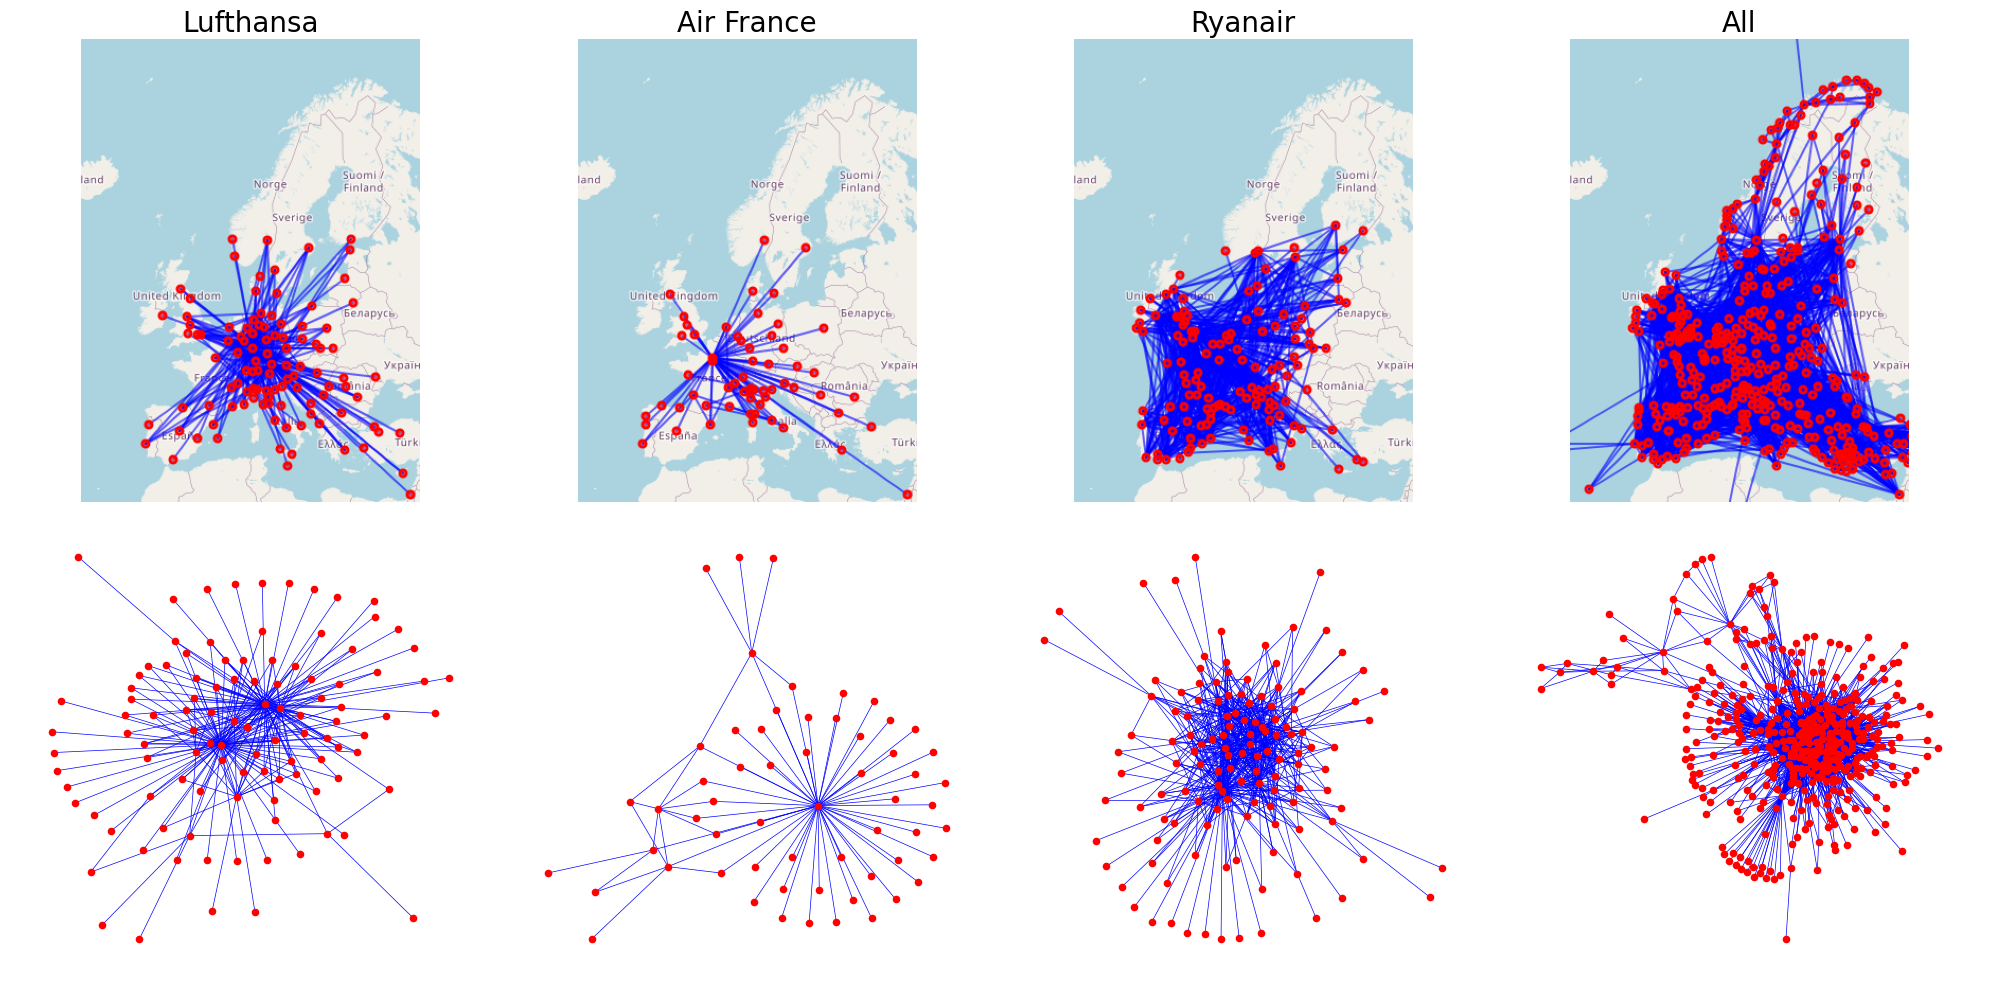

In [49]:
# Static plot of the newtorks to be studied
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax in axs.flatten():
    ax.set_axis_off()

plot_static_graph(
    network=ntw_lufthansa,
    png_file_name="ntw_lufthansa.png",
    column=0,
    network_name="Lufthansa",
    axs=axs,
)

plot_static_graph(
    network=ntw_air_france,
    png_file_name="ntw_air_france.png",
    column=1,
    network_name="Air France",
    axs=axs,
)

plot_static_graph(
    network=ntw_ryanair,
    png_file_name="ntw_ryanair.png",
    column=2,
    network_name="Ryanair",
    axs=axs,
)

plot_static_graph(
    network=ntw_all,
    png_file_name="ntw_all.png",
    column=3,
    network_name="All",
    axs=axs,
)

plt.tight_layout()
plt.show()


### **3. Microscale Analysis**

We will compute the following microscale measures for each airport (node) and each airline network:
- Degree centrality.
- Closeness centrality.
- Betweenness centrality.
- Eigenvector centrality.
- Page-rank centrality.
- Katz centrality.
- Clustering coefficient.

Data will be organized in the following structure:
```
f{airline_name}_microscale_data = [
    {
        f{airport_id}: {
            "degree_centrality": float,
            "closeness_centrality": float,
            ...
        },
        ...
    }
    ...
]
```

In [50]:
# List of airports ids

airports_ids = df_airports["node_id"].tolist()

# List of microscale measures
microscale_measures = [
    "degree_centrality",
    "closeness_centrality",
    "betweenness_centrality",
    "eigenvector_centrality",
    "pagerank_centrality",
    "katz_centrality",
    "clustering_coefficient",
]


def generate_microscale_data_structure(
    airports_ids: list[int],
    microscale_measures: list[str],
) -> list[dict]:
    """Generates a data structure for microscale measures.

    Args:
        airports_ids (list[int]) -- List of airport IDs.
        microscale_measures (list[str]) -- List of microscale measures.

    Returns:
        list[dict] -- Data structure for microscale measures.
    """
    return {
            airport_id: {
                centrality_measure: np.nan
                for centrality_measure in microscale_measures
            }
        for airport_id in airports_ids
        }

# Create a data structure for each airline
lufthansa_microscale_data = generate_microscale_data_structure(
    airports_ids=ntw_lufthansa.nodes(),
    microscale_measures=microscale_measures,
)
air_france_microscale_data = generate_microscale_data_structure(
    airports_ids=ntw_air_france.nodes(),
    microscale_measures=microscale_measures,
)
ryanair_microscale_data = generate_microscale_data_structure(
    airports_ids=ntw_ryanair.nodes(),
    microscale_measures=microscale_measures,
)
all_microscale_data = generate_microscale_data_structure(
    airports_ids=ntw_all.nodes(),
    microscale_measures=microscale_measures,
)


In [51]:
# Fill the data structure with the microscale measures
def fill_microscale_data_structure(
    microscale_data: list[dict],
    network: nx.Graph,
) -> None:
    """Fills the microscale data structure with measures.

    Args:
        microscale_data (list[dict]) -- Data structure for microscale measures.
        network (nx.Graph) -- NetworkX graph object.
    """

    for node in tqdm(network.nodes()):
        for measure in microscale_measures:
            match measure:
                case "degree_centrality":
                    microscale_data[node][measure] = nx.degree_centrality(network)[node]
                case "closeness_centrality":
                    microscale_data[node][measure] = nx.closeness_centrality(network)[node]
                case "betweenness_centrality":
                    microscale_data[node][measure] = nx.betweenness_centrality(network)[node]
                case "eigenvector_centrality":
                    microscale_data[node][measure] = nx.eigenvector_centrality(network)[node]
                case "pagerank_centrality":
                    microscale_data[node][measure] = nx.pagerank(network)[node]
                case "katz_centrality":
                    microscale_data[node][measure] = nx.katz_centrality_numpy(network)[node]
                    pass
                case "clustering_coefficient":
                    microscale_data[node][measure] = nx.clustering(network, node)
                case _:
                    raise ValueError(f"Unknown measure: {measure}")

    return microscale_data

# Save the microscale data to pickle files
def save_microscale_data(
    microscale_data: list[dict],
    airline_name: str,
) -> None:
    """Saves the microscale data to a pickle file.

    Args:
        microscale_data (list[dict]) -- Microscale data structure.
        airline_name (str) -- Name of the airline.
    """
    with open(OUTPUT_DIR / f"{airline_name}_microscale_data.pkl", "wb") as f:
        pickle.dump(microscale_data, f)

# Load the microscale data from pickle files
def load_microscale_data(
    airline_name: str,
) -> list[dict]:
    """Loads the microscale data from a pickle file.

    Args:
        airline_name (str) -- Name of the airline.

    Returns:
        list[dict] -- Microscale data structure.
    """
    with open(OUTPUT_DIR / f"{airline_name}_microscale_data.pkl", "rb") as f:
        microscale_data = pickle.load(f)
    return microscale_data


In [52]:
COMPUTE_MIRCOSCALE_DATA = False


In [54]:
# Fill the microscale data structure for each airline
if COMPUTE_MIRCOSCALE_DATA:
    lufthansa_microscale_data = fill_microscale_data_structure(
        microscale_data=lufthansa_microscale_data,
        network=ntw_lufthansa,
    )
    save_microscale_data(
        microscale_data=lufthansa_microscale_data,
        airline_name="lufthansa",
    )

    air_france_microscale_data = fill_microscale_data_structure(
        microscale_data=air_france_microscale_data,
        network=ntw_air_france,
    )
    save_microscale_data(
        microscale_data=air_france_microscale_data,
        airline_name="air_france",
    )

    ryanair_microscale_data = fill_microscale_data_structure(
        microscale_data=ryanair_microscale_data,
        network=ntw_ryanair,
    )
    save_microscale_data(
        microscale_data=ryanair_microscale_data,
        airline_name="ryanair",
    )

    all_microscale_data = fill_microscale_data_structure(
        microscale_data=all_microscale_data,
        network=ntw_all,
    )
    save_microscale_data(
        microscale_data=all_microscale_data,
        airline_name="all",
    )

else:
    lufthansa_microscale_data = load_microscale_data(
        airline_name="lufthansa",
    )
    air_france_microscale_data = load_microscale_data(
        airline_name="air_france",
    )
    ryanair_microscale_data = load_microscale_data(
        airline_name="ryanair",
    )
    all_microscale_data = load_microscale_data(
        airline_name="all",
    )




**Calculate the TOP-K central airports of each airline**

In [89]:
def top_k_central_nodes(
    microscale_data: dict,
    k: int,
    measure_name: str,
    *,
    df_airports: pd.DataFrame | None = None,
) -> list[tuple[int | str, float]]:
    """Returns the top k nodes for a given measure.

    Args:
        microscale_data (dict) -- Microscale data structure.
        k (int) -- Number of top nodes to return.
        measure_name (str) -- Measure to use for ranking.

    Returns:
        list[tuple[int, float]] -- List of tuples containing node ID and measure value.
    """
    sorted_nodes = sorted(
        microscale_data.items(),
        key=lambda x: x[1][measure_name],
        reverse=True,
    )

    sorted_nodes = [
        (node_id, microscale_data[node_id][measure_name])
        for node_id, _ in sorted_nodes
    ]

    if df_airports is not None:
        sorted_nodes = [
            (df_airports[df_airports["node_id"] == node_id]["name"].values[0], value)
            for node_id, value in sorted_nodes
        ]

    return sorted_nodes[:k]

# Function to print the top k nodes for a given measure
def print_top_k_central_nodes(
    microscale_data: dict,
    k: int,
    measure_name: str,
    *,
    df_airports: pd.DataFrame | None = None,
    out_file: Path | None = None,
) -> None:
    """Prints the top k nodes for a given measure.

    Args:
        microscale_data (dict) -- Microscale data structure.
        k (int) -- Number of top nodes to print.
        measure_name (str) -- Measure to use for ranking.
        df_airports (pd.DataFrame | None) -- DataFrame containing airport information.
    """
    top_nodes = top_k_central_nodes(
        microscale_data=microscale_data,
        k=k,
        measure_name=measure_name,
        df_airports=df_airports,
    )

    if out_file is not None:
        with open(out_file, "w") as f:
            f.write(f"Top {k} nodes for {measure_name}:\n")
            for node_id, value in top_nodes:
                f.write(f"{node_id:<40}: {value:.2f}\n")

    print(f"Top {k} nodes for {measure_name}:")
    for node_id, value in top_nodes:
        print(f"{' '*4}{node_id:<40}: {value:.2f}")


In [91]:
k = 5


In [92]:
print(f"{'-'*20}< LUFTHANSA >{'-'*20}")
for measure in microscale_measures:
    print_top_k_central_nodes(
        microscale_data=lufthansa_microscale_data,
        k=k,
        measure_name=measure,
        df_airports=df_airports,
    )

# Save the printed output to a file
output_file = OUTPUT_DIR / "lufthansa_top_k_central_nodes.txt"
with open(output_file, "w") as f:
    f.write(f"{'-'*20}< LUFTHANSA >{'-'*20}\n")
    for measure in microscale_measures:
        top_nodes = top_k_central_nodes(
            microscale_data=lufthansa_microscale_data,
            k=k,
            measure_name=measure,
            df_airports=df_airports,
        )
        f.write(f"Top {k} nodes for {measure}:\n")
        for node_id, value in top_nodes:
            f.write(f"{' '*4}{node_id:<40}: {value:.2f}\n")
        f.write("\n")


--------------------< LUFTHANSA >--------------------
Top 5 nodes for degree_centrality:
    Munich Airport                          : 0.74
    Frankfurt Airport                       : 0.73
    Düsseldorf Airport                      : 0.40
    Hamburg Helmut Schmidt Airport          : 0.18
    Milan Malpensa International Airport    : 0.16
Top 5 nodes for closeness_centrality:
    Munich Airport                          : 0.79
    Frankfurt Airport                       : 0.79
    Düsseldorf Airport                      : 0.61
    Hamburg Helmut Schmidt Airport          : 0.54
    Milan Malpensa International Airport    : 0.53
Top 5 nodes for betweenness_centrality:
    Munich Airport                          : 0.48
    Frankfurt Airport                       : 0.46
    Düsseldorf Airport                      : 0.09
    Bremen Airport                          : 0.05
    Milan Malpensa International Airport    : 0.04
Top 5 nodes for eigenvector_centrality:
    Frankfurt Airport       

In [93]:
print(f"{'-'*20}< AIR FRANCE >{'-'*20}")
for measure in microscale_measures:
    print_top_k_central_nodes(
        microscale_data=air_france_microscale_data,
        k=k,
        measure_name=measure,
        df_airports=df_airports,
    )

# Save the printed output to a file
output_file = OUTPUT_DIR / "air_france_top_k_central_nodes.txt"
with open(output_file, "w") as f:
    f.write(f"{'-'*20}< AIR FRANCE >{'-'*20}\n")
    for measure in microscale_measures:
        top_nodes = top_k_central_nodes(
            microscale_data=air_france_microscale_data,
            k=k,
            measure_name=measure,
            df_airports=df_airports,
        )
        f.write(f"Top {k} nodes for {measure}:\n")
        for node_id, value in top_nodes:
            f.write(f"{' '*4}{node_id:<40}: {value:.2f}\n")
        f.write("\n")


--------------------< AIR FRANCE >--------------------
Top 5 nodes for degree_centrality:
    Charles de Gaulle International Airport : 0.86
    Lyon Saint-Exupéry Airport              : 0.10
    Paris-Orly Airport                      : 0.10
    Rome–Fiumicino Leonardo da Vinci International Airport: 0.10
    Josep Tarradellas Barcelona-El Prat Airport: 0.07
Top 5 nodes for closeness_centrality:
    Charles de Gaulle International Airport : 0.88
    Paris-Orly Airport                      : 0.51
    Rome–Fiumicino Leonardo da Vinci International Airport: 0.51
    Josep Tarradellas Barcelona-El Prat Airport: 0.50
    Milan Malpensa International Airport    : 0.50
Top 5 nodes for betweenness_centrality:
    Charles de Gaulle International Airport : 0.96
    Paris-Orly Airport                      : 0.10
    Rome–Fiumicino Leonardo da Vinci International Airport: 0.07
    Milan Malpensa International Airport    : 0.05
    Josep Tarradellas Barcelona-El Prat Airport: 0.02
Top 5 nodes for 

In [94]:
print(f"{'-'*20}< RYANAIR >{'-'*20}")
for measure in microscale_measures:
    print_top_k_central_nodes(
        microscale_data=ryanair_microscale_data,
        k=k,
        measure_name=measure,
        df_airports=df_airports,
    )

# Save the printed output to a file
output_file = OUTPUT_DIR / "ryanair_top_k_central_nodes.txt"
with open(output_file, "w") as f:
    f.write(f"{'-'*20}< RYANAIR >{'-'*20}\n")
    for measure in microscale_measures:
        top_nodes = top_k_central_nodes(
            microscale_data=ryanair_microscale_data,
            k=k,
            measure_name=measure,
            df_airports=df_airports,
        )
        f.write(f"Top {k} nodes for {measure}:\n")
        for node_id, value in top_nodes:
            f.write(f"{' '*4}{node_id:<40}: {value:.2f}\n")
        f.write("\n")


--------------------< RYANAIR >--------------------
Top 5 nodes for degree_centrality:
    London Stansted Airport                 : 0.67
    Dublin Airport                          : 0.43
    Milan Bergamo Airport / Antonio Locatelli Air Base: 0.35
    Brussels South Charleroi Airport        : 0.29
    Alicante-Elche Miguel Hernández Airport : 0.25
Top 5 nodes for closeness_centrality:
    London Stansted Airport                 : 0.73
    Dublin Airport                          : 0.63
    Milan Bergamo Airport / Antonio Locatelli Air Base: 0.59
    Alicante-Elche Miguel Hernández Airport : 0.56
    Girona-Costa Brava Airport              : 0.56
Top 5 nodes for betweenness_centrality:
    London Stansted Airport                 : 0.43
    Dublin Airport                          : 0.13
    Brussels South Charleroi Airport        : 0.07
    Milan Bergamo Airport / Antonio Locatelli Air Base: 0.06
    Alicante-Elche Miguel Hernández Airport : 0.05
Top 5 nodes for eigenvector_centrality:


In [95]:
print(f"{'-'*20}< ALL >{'-'*20}")
for measure in microscale_measures:
    print_top_k_central_nodes(
        microscale_data=lufthansa_microscale_data,
        k=k,
        measure_name=measure,
        df_airports=df_airports,
    )

# Save the printed output to a file
output_file = OUTPUT_DIR / "all_top_k_central_nodes.txt"
with open(output_file, "w") as f:
    f.write(f"{'-'*20}< ALL >{'-'*20}\n")
    for measure in microscale_measures:
        top_nodes = top_k_central_nodes(
            microscale_data=lufthansa_microscale_data,
            k=k,
            measure_name=measure,
            df_airports=df_airports,
        )
        f.write(f"Top {k} nodes for {measure}:\n")
        for node_id, value in top_nodes:
            f.write(f"{' '*4}{node_id:<40}: {value:.2f}\n")
        f.write("\n")


--------------------< ALL >--------------------
Top 5 nodes for degree_centrality:
    Munich Airport                          : 0.74
    Frankfurt Airport                       : 0.73
    Düsseldorf Airport                      : 0.40
    Hamburg Helmut Schmidt Airport          : 0.18
    Milan Malpensa International Airport    : 0.16
Top 5 nodes for closeness_centrality:
    Munich Airport                          : 0.79
    Frankfurt Airport                       : 0.79
    Düsseldorf Airport                      : 0.61
    Hamburg Helmut Schmidt Airport          : 0.54
    Milan Malpensa International Airport    : 0.53
Top 5 nodes for betweenness_centrality:
    Munich Airport                          : 0.48
    Frankfurt Airport                       : 0.46
    Düsseldorf Airport                      : 0.09
    Bremen Airport                          : 0.05
    Milan Malpensa International Airport    : 0.04
Top 5 nodes for eigenvector_centrality:
    Frankfurt Airport             